meanatomicpowerplant1 0.5 0.5 0.5
meanchester3 1.5 1.5 1.5
meanrecreation5 2.5 2.5 2.5


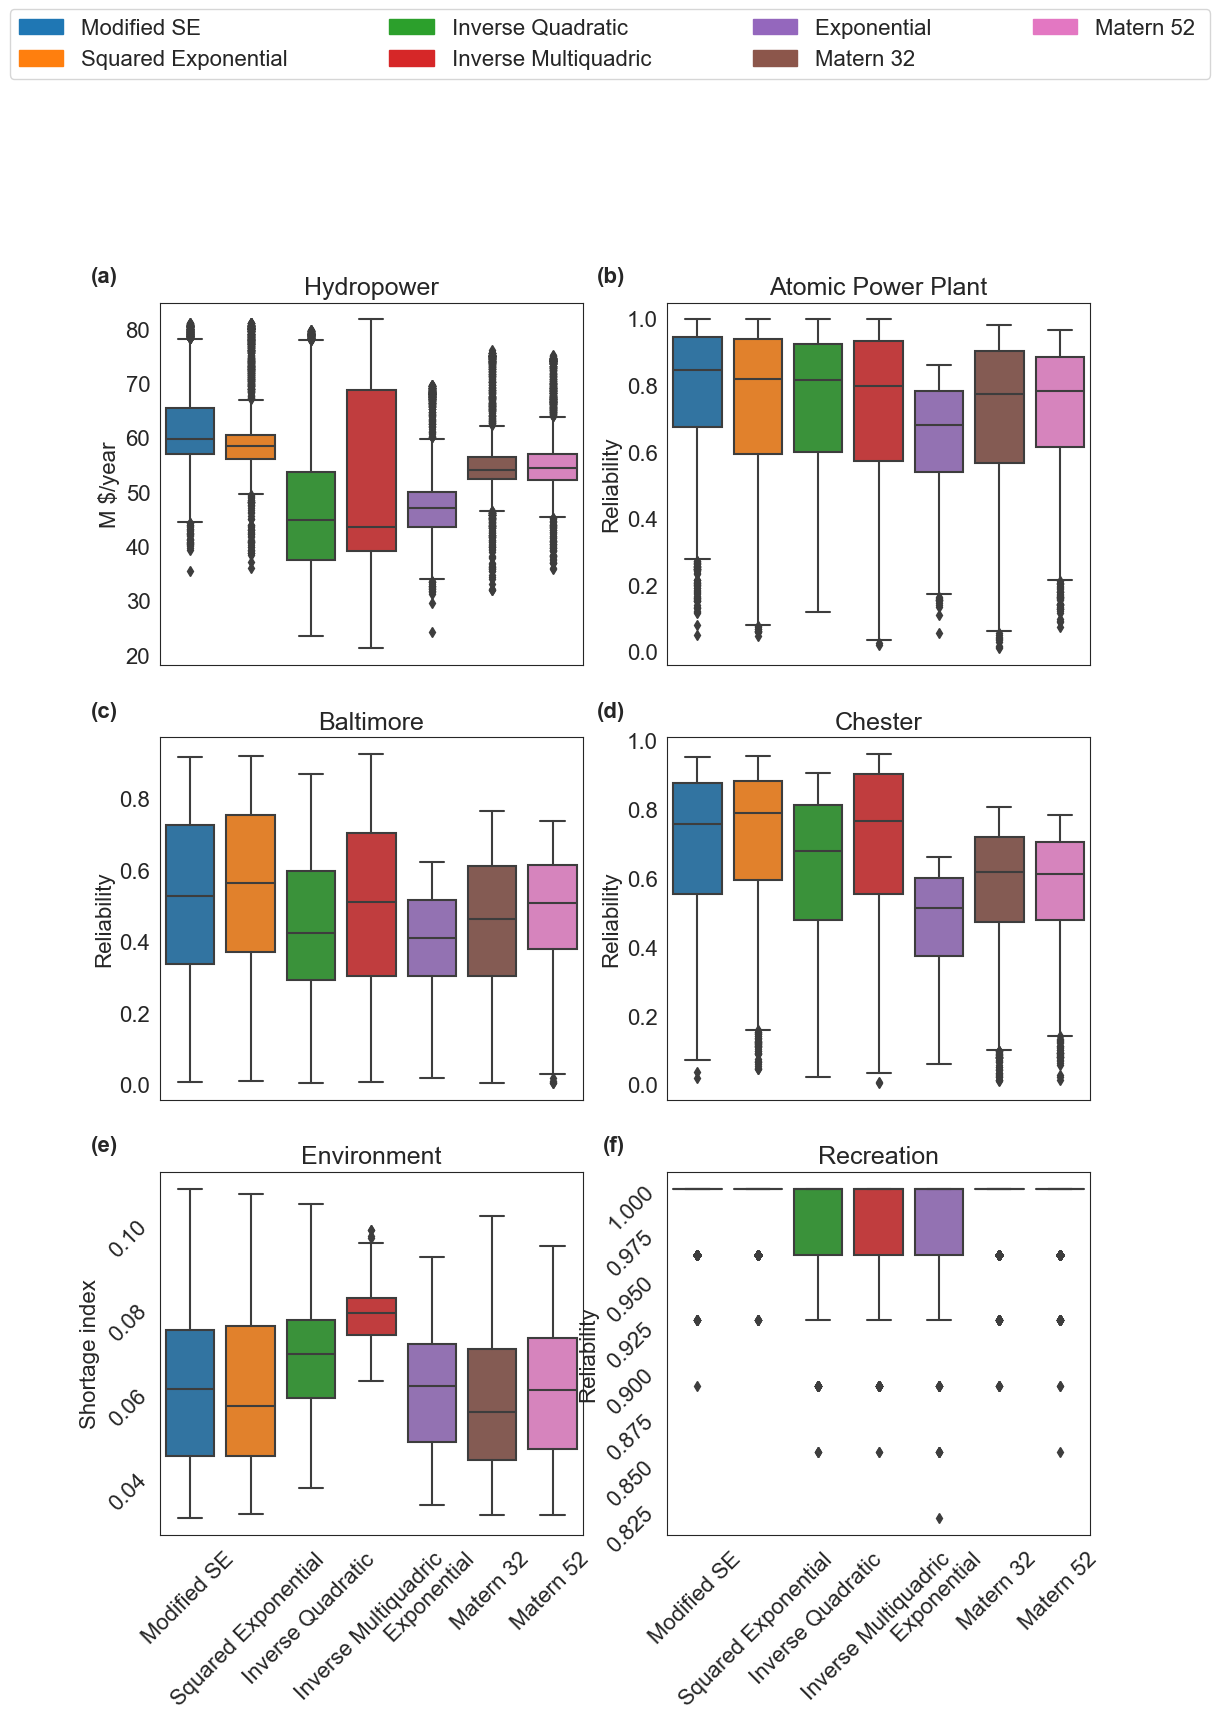

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rbf_functions
import numpy as np

sns.set_style("white")

rbfs = [
    rbf_functions.original_rbf,
    rbf_functions.squared_exponential_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

def format_rbf_name(name):
    # Convert underscores to spaces and capitalize the first letter of each word
    formatted_name = ' '.join(word.capitalize() for word in name.split('_'))

    # Convert "Rbf" to "RBF"
    formatted_name = formatted_name.replace("Rbf", "")
    formatted_name = formatted_name.replace("Original", "Modified SE")

    # Convert "Matern32" to "Matern 32" and "Matern52" to "Matern 52"
    formatted_name = formatted_name.replace("Matern32", "Matern 32")
    formatted_name = formatted_name.replace("Matern52", "Matern 52")

    return formatted_name

def replace_title(title):
    title_mapping = {
        "hydropower": "Hydropower",
        "atomicpowerplant": "Atomic Power Plant",
        "baltimore" : "Baltimore",
        "chester" : "Chester",
        "environment" : "Environment",
        "recreation" : "Recreation"
    }
    return title_mapping.get(title, title)  # If not in the mapping, return original title

# Load reference set for each RBF
pareto_sets = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = "./refsets/"
    results = pd.read_csv(output_dir + name + "_refset.csv")
    pareto_sets[name] = results


for k, v in pareto_sets.items():
    v["rbf"] = k

combined = pd.concat(pareto_sets.values())

l = []
fontsize = 16
plt.rcParams.update({
    'font.size': fontsize,               # Default fontsize for text added to plots (xlabel, ylabel, title, etc.)
    'axes.labelsize': fontsize,          # Fontsize of the x and y labels
    'xtick.labelsize': fontsize,         # Fontsize of the tick labels
    'ytick.labelsize': fontsize,         # Fontsize of the tick labels
    'legend.fontsize': fontsize,         # Fontsize in the legend
    'axes.titlesize': 18          # Fontsize of subplot titles
})
for n in rbfs:
    l.append(n.__name__)

fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12, 16))

for i, entry in enumerate(combined.columns[0:-1]):
    x = i / 2
    data = combined[[entry, "rbf"]]
    if i % 2:
        sns.boxplot(ax=axes[int(x), 1], data=data, y=entry, x="rbf", order=l)
        axes[int(x), 1].set_title(replace_title(entry))
        axes[int(x), 1].set_ylabel("Reliability")
        axes[int(x), 1].set_xticklabels([format_rbf_name(label.get_text()) for label in axes[int(x), 1].get_xticklabels()])
        axes[int(x), 1].set_xlabel(None)
        print('mean'+str(entry)+str(i), np.mean(x), np.percentile(x,0.25), np.percentile(x,0.75))
    else:
        sns.boxplot(ax=axes[int(x), 0], data=data, y=entry, x="rbf", order=l)
        axes[int(x), 0].set_title(replace_title(entry))
        axes[int(x), 0].set_xticklabels([format_rbf_name(label.get_text()) for label in axes[int(x), 0].get_xticklabels()])
        axes[int(x), 0].set_xlabel(None)
        if x == 0:
            axes[int(x), 0].set_ylabel("M $/year")
        elif x == 2:
            axes[int(x), 0].set_ylabel("Shortage index")
        else:
            axes[int(x), 0].set_ylabel("Reliability")

    axes[2, 0].tick_params(labelrotation=45)
    axes[2, 1].tick_params(labelrotation=45)

subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

for i, axi in enumerate(axes.flat):
    axi.text(-0.1, 1.1, subplot_labels[i], transform=axi.transAxes,
             fontsize=16, fontweight='bold', va='top', ha='right')

# make a single figure level legend
handles = []
colors = sns.color_palette()
for (i, rbf) in enumerate(rbfs):
    name = format_rbf_name(rbf.__name__)  # Use the format_rbf_name function to format the name
    patch = mpatches.Patch(color=colors[i], label=name)
    handles.append(patch)

fig.legend(
    handles=handles,
    ncol=4,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="lower left",
    mode="expand",
    borderaxespad=0,
)


# fig.tight_layout()
# plt.savefig(f"./figs/paper_figures/png/box_plots_Susquehanna.png", bbox_inches="tight")
# plt.savefig(f"./figs/paper_figures/pdf/box_plots_Susquehanna.pdf", bbox_inches="tight")


In [2]:

import pandas as pd
from tabulate import tabulate

# Assuming you have a DataFrame called "combined" with a column named "rbf"
unique_rbfs = combined["rbf"].unique()

# Create a dictionary to store the results for each "rbf"
rbf_metrics = {}
objectives = [
        "hydropower",
        "atomicpowerplant",
        "baltimore",
        "chester",
        "environment",
        "recreation"
]

# Iterate through each "rbf" value
for rbf_value in unique_rbfs:
    # Filter rows for the current "rbf"
    rbf_rows = combined[combined["rbf"] == rbf_value]

    # Initialize an empty dictionary for the current "rbf" value
    rbf_metrics[rbf_value] = {}

    # Iterate through each objective and calculate desired statistics
    for objective in objectives:
        objective_column = rbf_rows[objective]
        percentile_25 = objective_column.quantile(0.25)
        percentile_75 = objective_column.quantile(0.75)
        median = objective_column.median()
        min_value = objective_column.min()
        max_value = objective_column.max()

        # Store the results in the dictionary for the current "rbf" and objective
        rbf_metrics[rbf_value][objective] = {
            "Percentile_25": percentile_25,
            "Percentile_75": percentile_75,
            "Median": median,
            "Min": min_value,
            "Max": max_value
        }

# Create a list of dictionaries suitable for tabulation
table_data = []
for rbf_value, objective_metrics in rbf_metrics.items():
    row = {"RBF": rbf_value}
    row.update(objective_metrics)
    table_data.append(row)

# Define table headers as a dictionary
headers = {"RBF": "RBF"}
for objective in objectives:
    headers.update({f"{objective}_Percentile_25": f"{objective} 25th Percentile",
                    f"{objective}_Percentile_75": f"{objective} 75th Percentile",
                    f"{objective}_Median": f"{objective} Median",
                    f"{objective}_Min": f"{objective} Min",
                    f"{objective}_Max": f"{objective} Max"})

# Generate LaTeX table
latex_table = tabulate(table_data, headers=headers, tablefmt="latex_raw")

# Print the LaTeX table
print(latex_table)


\begin{tabular}{lllllll}
\hline
 RBF                      & hydropower                                                                                                                                                  & atomicpowerplant                                                                                                                                               & baltimore                                                                                                                                                       & chester                                                                                                                                                         & environment                                                                                                                                                        & recreation                                                                                                        \\
\hline
 origina